# 准备数据

In [3]:
# 过滤Alphalens的warning
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# 加载模块
import polars as pl

from vnpy.trader.constant import Interval

from vnpy.alpha import AlphaLab

In [5]:
# 创建数据中心
lab: AlphaLab = AlphaLab("./lab/csi300")

In [6]:
# 设置任务参数
name = "300_mlp"
index_symbol: str = "000300.SSE"
start: str = "2008-01-01"
end: str = "2023-12-31"
interval: Interval = Interval.DAILY
extended_days: int = 100

In [7]:
# 加载所有成分股代码
component_symbols: list[str] = lab.load_component_symbols(index_symbol, start, end)

# 特征计算

In [6]:
# 加载模块
from datetime import datetime
from functools import partial

from vnpy.trader.constant import Interval

from vnpy.alpha.dataset import (
    AlphaDataset,
    process_drop_na,
    process_robust_zscore_norm,
    process_fill_na,
    process_cs_rank_norm,
    to_datetime,
)
from vnpy.alpha.dataset.datasets.alpha_158 import Alpha158

In [7]:
# 加载成分股数据
df: pl.DataFrame = lab.load_bar_df(
    component_symbols, interval, start, end, extended_days
)

In [8]:
# 设置数据时间段
train_period: tuple[str, str] = ("2008-01-01", "2014-12-31")
valid_period: tuple[str, str] = ("2015-01-01", "2016-12-31")
test_period: tuple[str, str] = ("2017-01-01", "2020-8-31")

In [9]:
# 创建数据集对象
dataset: AlphaDataset = Alpha158(
    df,
    train_period=train_period,
    valid_period=valid_period,
    test_period=test_period,
)

In [10]:
# 添加数据预处理器
fit_start_time: datetime = to_datetime(train_period[0])
fit_end_time: datetime = to_datetime(train_period[1])

dataset.add_processor(
    "infer",
    partial(
        process_robust_zscore_norm,
        fit_start_time=fit_start_time,
        fit_end_time=fit_end_time,
    ),
)
dataset.add_processor("infer", partial(process_fill_na, fill_value=0, fill_label=False))

dataset.add_processor("learn", partial(process_drop_na, names=["label"]))
dataset.add_processor("learn", partial(process_cs_rank_norm, names=["label"]))

In [11]:
# 收集指数成分过滤器
filters: dict[str, list[str]] = lab.load_component_filters(index_symbol, start, end)

In [12]:
# 准备特征和标签数据
dataset.prepare_data(filters, max_workers=3)

2025-03-27 09:45:49 开始计算表达式因子特征


100%|██████████| 159/159 [1:01:22<00:00, 23.16s/it]

2025-03-27 10:47:11 开始合并结果数据因子特征



0it [00:00, ?it/s]


2025-03-27 10:47:12 开始筛选成分股数据


100%|██████████| 819/819 [00:14<00:00, 58.17it/s] 


Dropped 7.9% entries from factor data: 0.4% in forward returns computation and 7.5% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


min       max      mean       std   count    count %
factor_quantile                                                           
1.0              0.000000  0.783112  0.092955  0.131673  184949  10.066775
2.0              0.000571  0.849006  0.241236  0.181801  183716   9.999663
3.0              0.010751  0.886908  0.321495  0.204981  183114   9.966896
4.0              0.016062  0.914302  0.388077  0.216530  183642   9.995635
5.0              0.027016  0.936739  0.450759  0.221084  183948  10.012290
6.0              0.047668  0.954686  0.514230  0.219328  182906   9.955574
7.0              0.071943  0.967680  0.581944  0.210957  183341   9.979251
8.0              0.101998  0.980325  0.659180  0.193256  183395   9.982191
9.0              0.148624  0.998517  0.752254  0.162710  183430   9.984096
10.0             0.234618  1.000000  0.888934  0.113950  184781  10.057630

Returns Analysis


1D     5D    10D
Ann. alpha                                      0.100 -0.035 -0.002
beta                                            0.024  0.024  0.032
Mean Period Wise Return Top Quantile (bps)     15.216  2.036  3.604
Mean Period Wise Return Bottom Quantile (bps)  -4.978  0.335  1.358
Mean Period Wise Spread (bps)                  20.194  1.717  2.422

<Figure size 640x480 with 0 Axes>

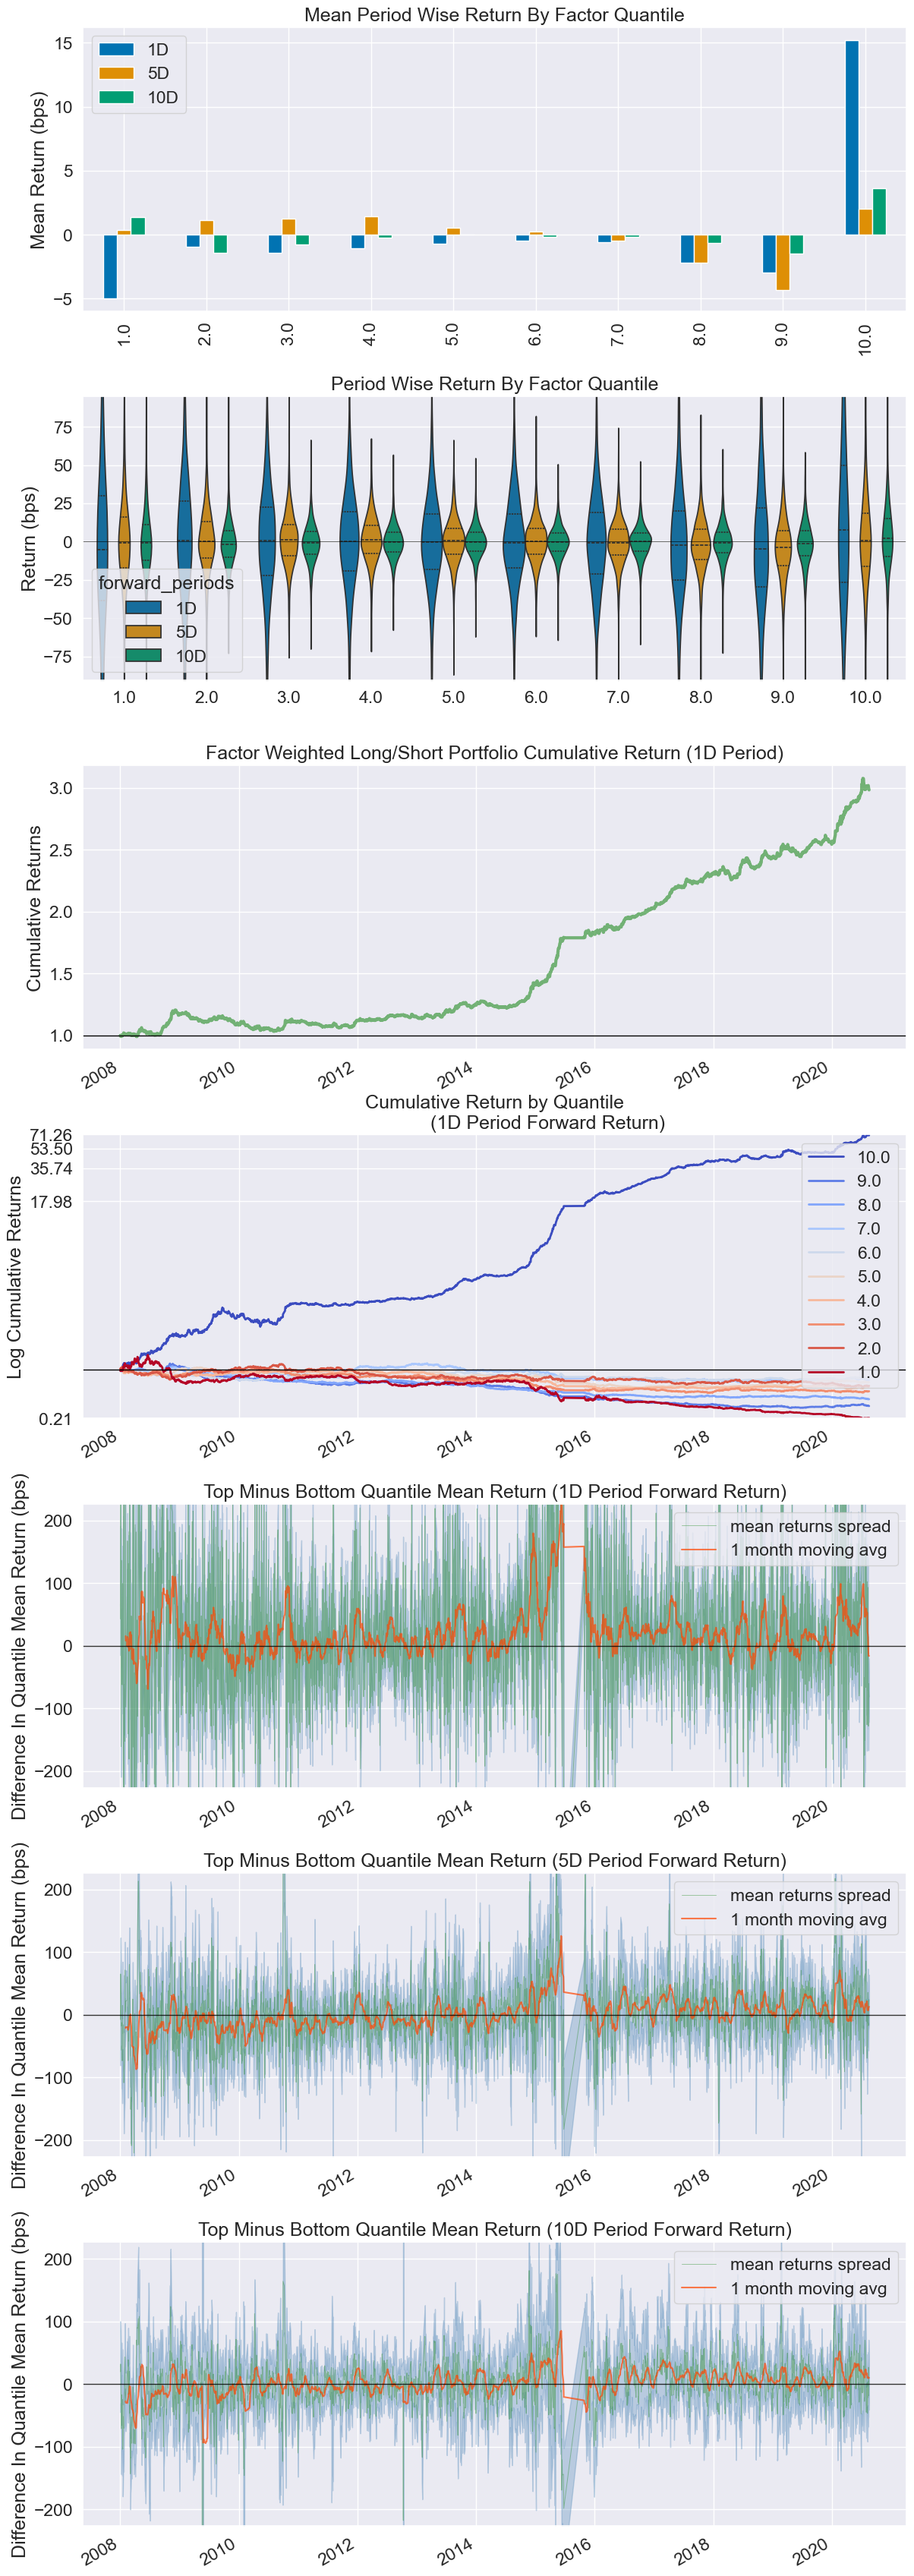

Information Analysis


1D     5D    10D
IC Mean          -0.029 -0.031 -0.005
IC Std.           0.137  0.129  0.128
Risk-Adjusted IC -0.209 -0.237 -0.038
t-stat(IC)          NaN    NaN    NaN
p-value(IC)         NaN    NaN    NaN
IC Skew             NaN    NaN    NaN
IC Kurtosis         NaN    NaN    NaN

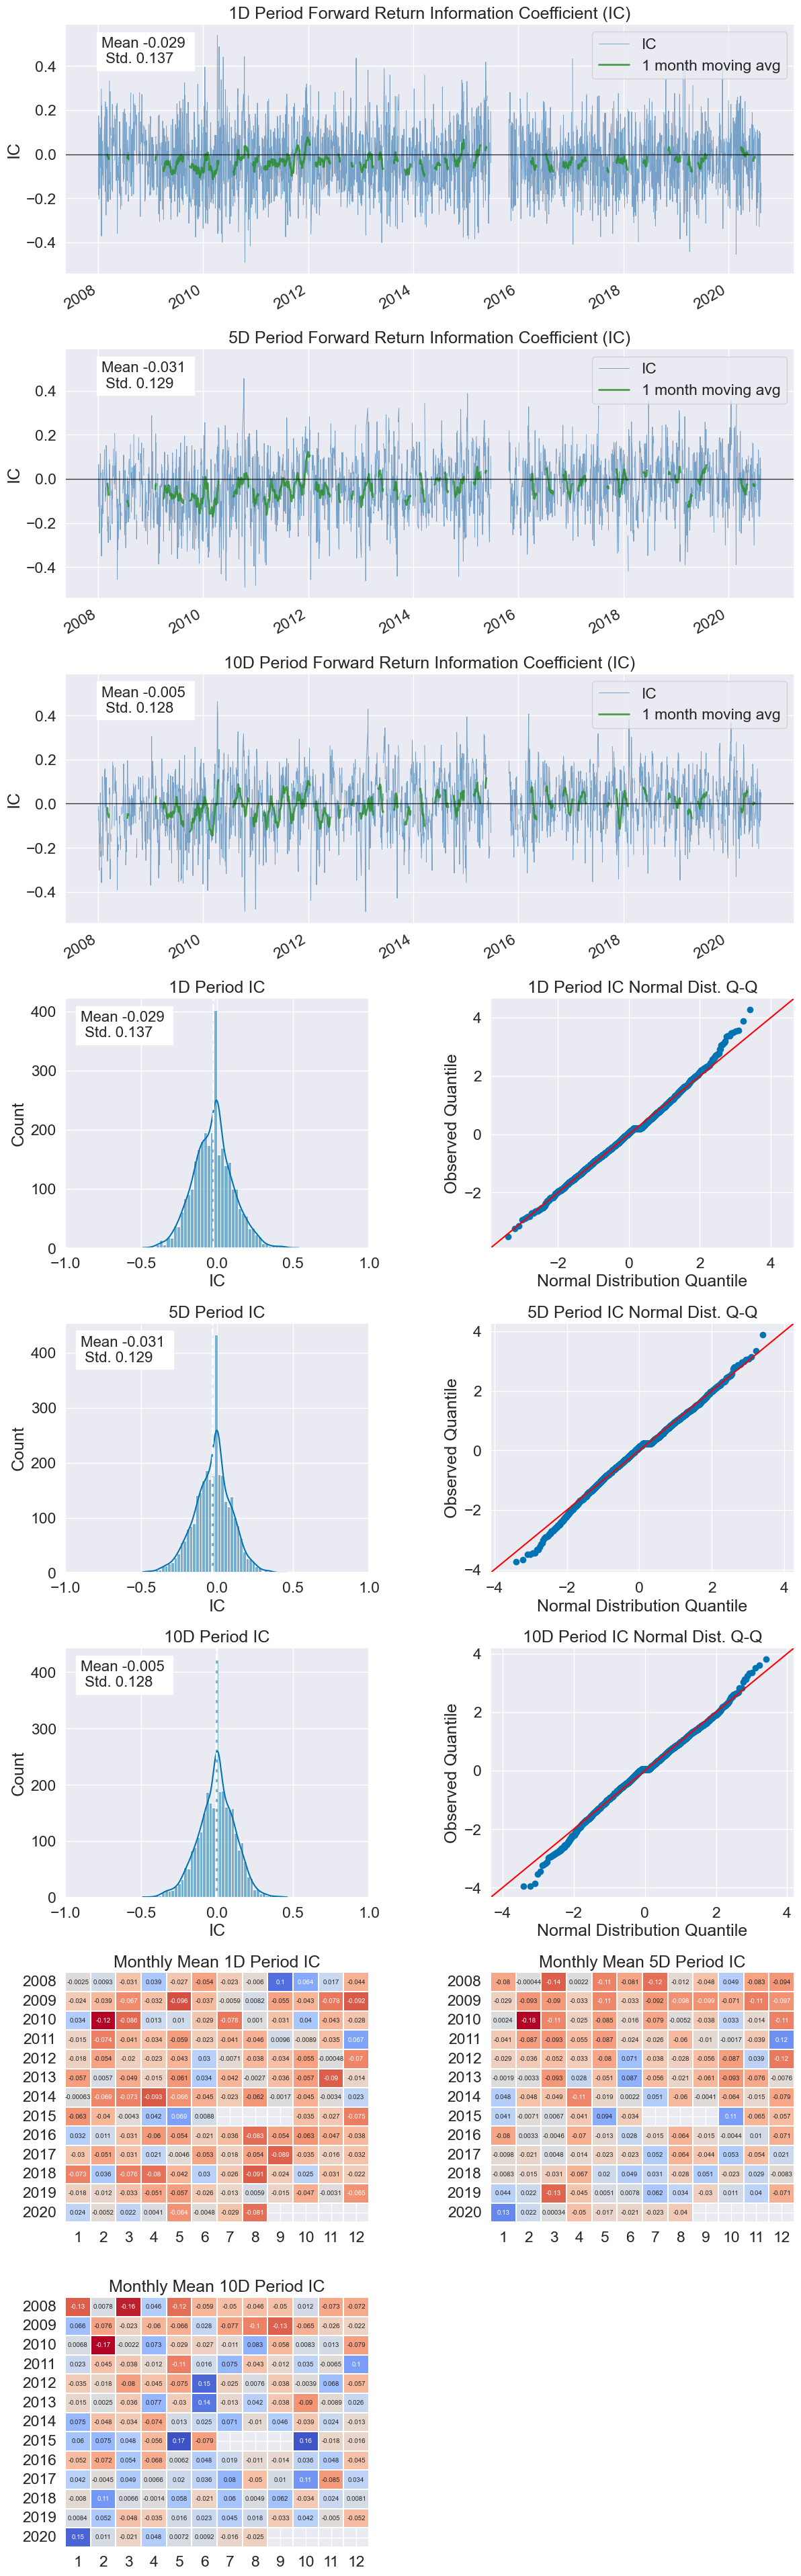

c:\Python313\Lib\site-packages\alphalens\utils.py:928: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


Turnover Analysis


1D     5D    10D
Quantile 1.0 Mean Turnover    0.470  0.660  0.674
Quantile 2.0 Mean Turnover    0.752  0.906  0.892
Quantile 3.0 Mean Turnover    0.818  0.899  0.894
Quantile 4.0 Mean Turnover    0.845  0.894  0.893
Quantile 5.0 Mean Turnover    0.856  0.891  0.893
Quantile 6.0 Mean Turnover    0.860  0.896  0.895
Quantile 7.0 Mean Turnover    0.853  0.897  0.898
Quantile 8.0 Mean Turnover    0.835  0.899  0.896
Quantile 9.0 Mean Turnover    0.794  0.901  0.892
Quantile 10.0 Mean Turnover   0.673  0.893  0.885

1D     5D    10D
Mean Factor Rank Autocorrelation  0.605  0.038  0.083

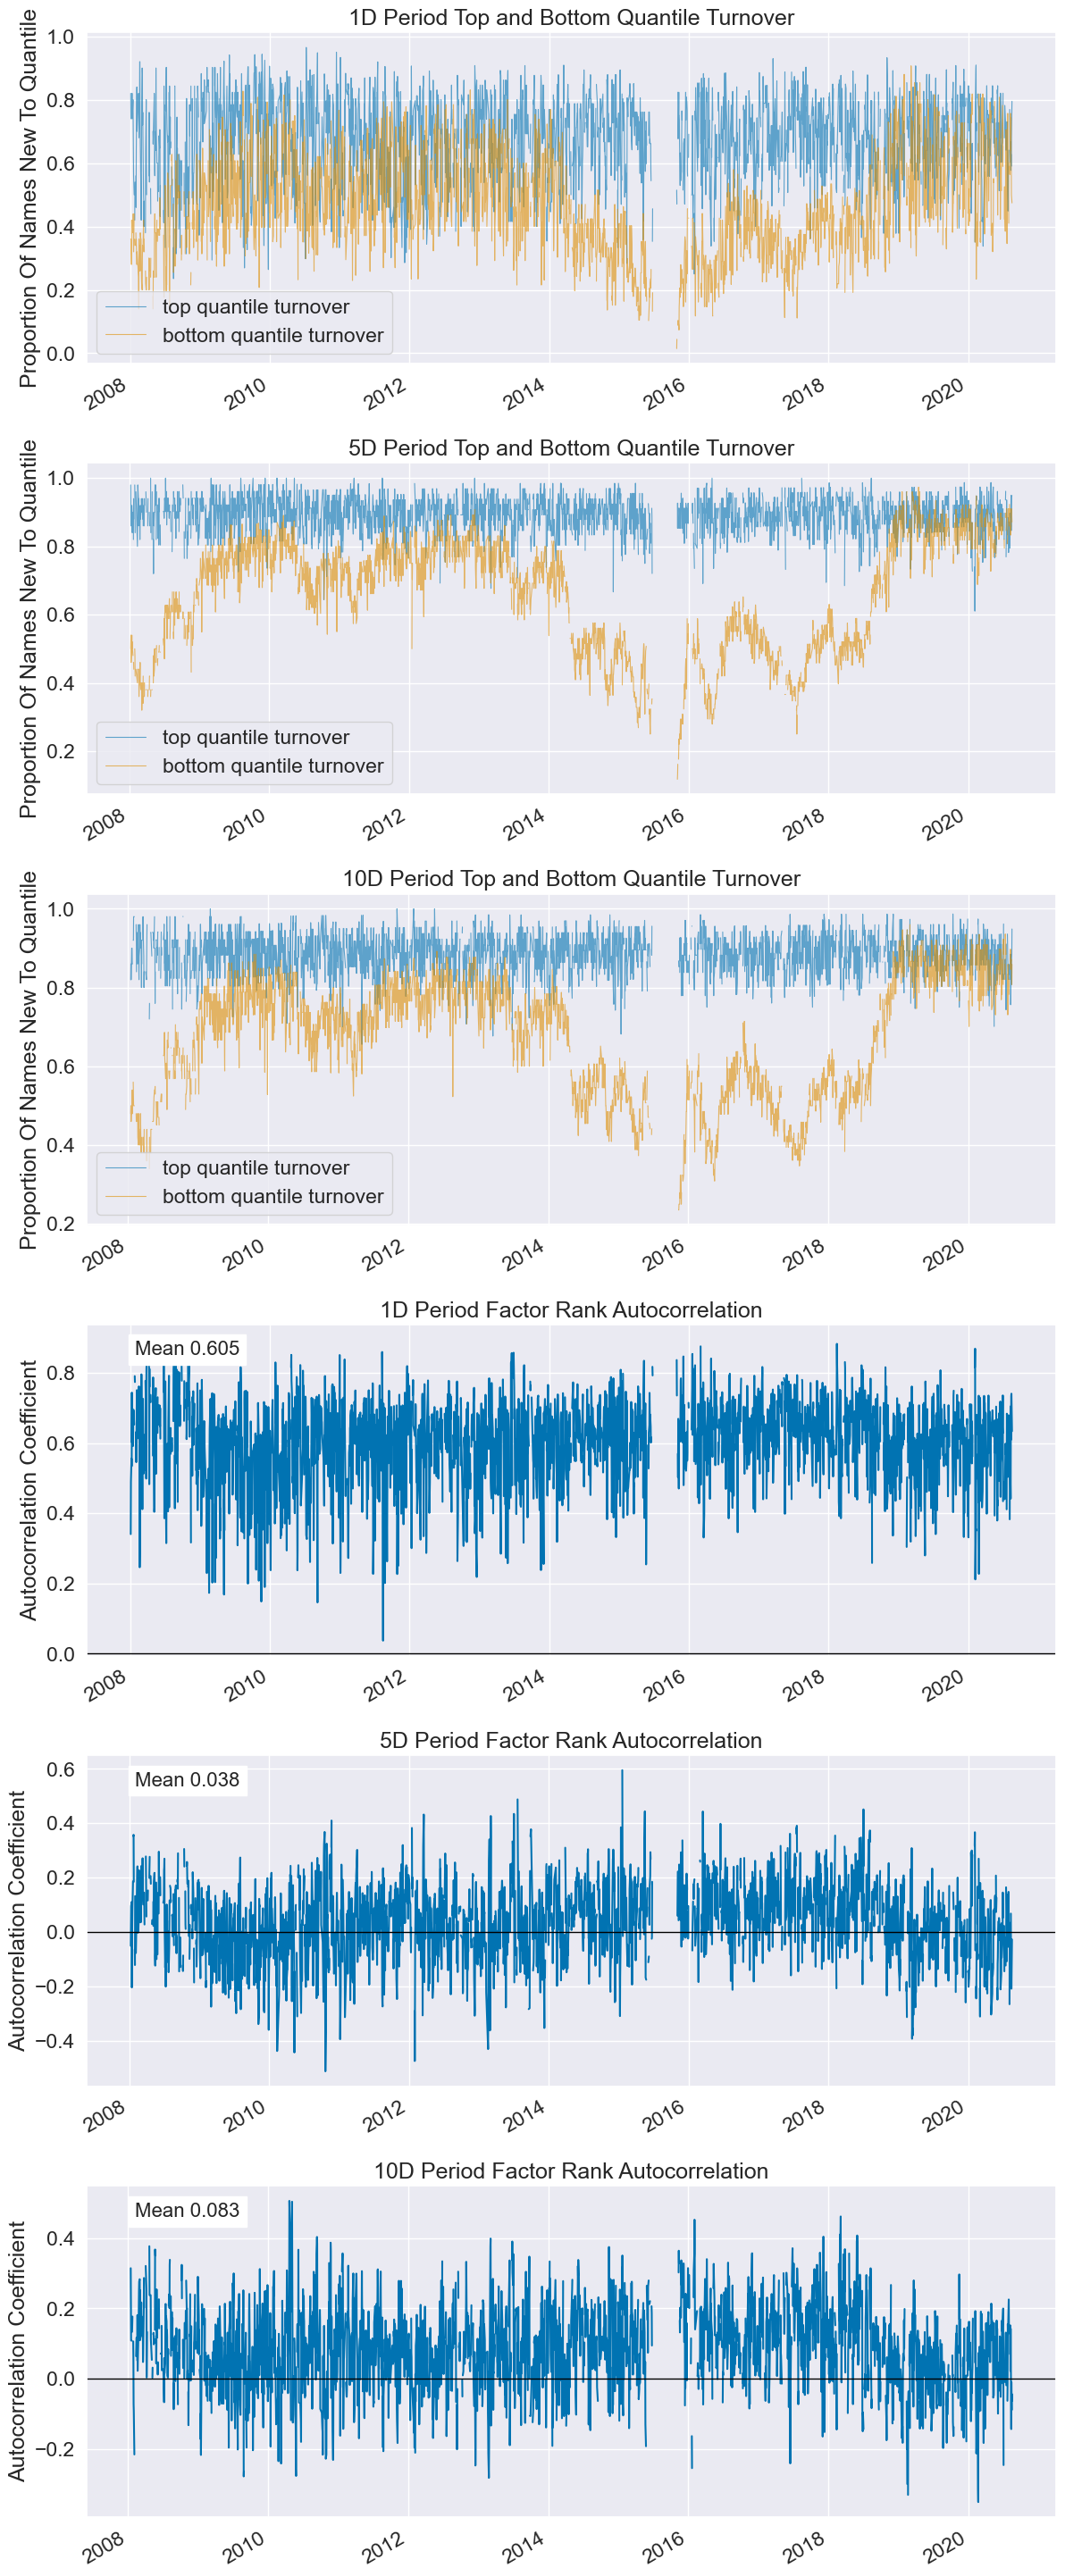

In [13]:
# 特征表现分析
dataset.show_feature_performance("rsv_5")

In [14]:
# 保存到文件缓存
lab.save_dataset(name, dataset)

# 模型训练

In [8]:
# 加载模块
import numpy as np

from vnpy.alpha import Segment, AlphaDataset, AlphaModel

from vnpy.alpha.model.models.mlp_model import MlpModel

In [9]:
# 从文件缓存加载
dataset: AlphaDataset = lab.load_dataset(name)

In [10]:
# 创建模型对象
kwargs = {
    "input_size": 158,
    "hidden_sizes": (256,),
    "lr": 0.002,
    "optimizer": "adam",
    "n_epochs": 8000,
    "batch_size": 8192,
    "weight_decay": 0.0002,
    "seed": 42,
}

model: AlphaModel = MlpModel(**kwargs)

c:\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
# 使用数据集训练模型
model.fit(dataset)

2025-03-27 11:00:09 [Step 20]: train_loss 1.234455, valid_loss 1.069892
2025-03-27 11:00:09 	验证集损失从 inf 降低到 1.069892


c:\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:1370: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2025-03-27 11:00:10 [Step 40]: train_loss 1.078463, valid_loss 1.019398
2025-03-27 11:00:10 	验证集损失从 1.069892 降低到 1.019398
2025-03-27 11:00:11 [Step 60]: train_loss 1.050789, valid_loss 1.007906
2025-03-27 11:00:11 	验证集损失从 1.019398 降低到 1.007906
2025-03-27 11:00:12 [Step 80]: train_loss 1.037068, valid_loss 1.001991
2025-03-27 11:00:12 	验证集损失从 1.007906 降低到 1.001991
2025-03-27 11:00:12 [Step 100]: train_loss 1.029311, valid_loss 1.002019
2025-03-27 11:00:13 [Step 120]: train_loss 1.023081, valid_loss 0.995843
2025-03-27 11:00:13 	验证集损失从 1.001991 降低到 0.995843
2025-03-27 11:00:14 [Step 140]: train_loss 1.018514, valid_loss 0.995848
2025-03-27 11:00:14 [Step 160]: train_loss 1.012256, valid_loss 0.997683
2025-03-27 11:00:15 [Step 180]: train_loss 1.003013, valid_loss 0.996933
2025-03-27 11:00:16 [Step 200]: train_loss 1.007771, valid_loss 0.995588
2025-03-27 11:00:16 	验证集损失从 0.995843 降低到 0.995588
2025-03-27 11:00:17 [Step 220]: train_loss 1.004081, valid_loss 0.995166
2025-03-27 11:00:17 	验证

In [12]:
# 查看模型细节
model.detail()

2025-03-27 11:01:07 输入特征维度: 158
2025-03-27 11:01:07 隐藏层大小: (256,)
2025-03-27 11:01:07 模型总参数量: 41,473
2025-03-27 11:01:07 训练设备: cpu
2025-03-27 11:01:07 当前学习率: 0.002
2025-03-27 11:01:07 批次大小: 8192


Importance
Feature            
rank_5     0.002526
rank_10    0.002153
min_5      0.001780
std_5      0.001735
qtlu_5     0.001633
...             ...
cord_5     0.000630
imax_20    0.000629
rank_60    0.000605
imin_30    0.000581
cord_10    0.000407

[158 rows x 1 columns]

In [13]:
# 保存模型
lab.save_model(name, model)

# 预测信号

In [14]:
model: AlphaModel = lab.load_model(name)

In [15]:
# 用模型在测试集上预测
pre: np.ndarray = model.predict(dataset, Segment.TEST)

# 加载测试集数据
df_t: pl.DataFrame = dataset.fetch_infer(Segment.TEST)

# 合并预测信号列
df_t = df_t.with_columns(pl.Series(pre).alias("signal"))

# 提取信号数据
signal: pl.DataFrame = df_t["datetime", "vt_symbol", "signal"]

Dropped 1.1% entries from factor data: 1.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Quantiles Statistics


min       max      mean       std  count  count %
factor_quantile                                                        
1               -0.917946 -0.011702 -0.191091  0.081716  26460     10.0
2               -0.379574  0.048505 -0.099854  0.047091  26460     10.0
3               -0.299041  0.084674 -0.057940  0.043638  26460     10.0
4               -0.251981  0.135914 -0.025985  0.041994  26460     10.0
5               -0.215594  0.171405  0.002050  0.041480  26460     10.0
6               -0.184330  0.214541  0.028800  0.041226  26460     10.0
7               -0.149439  0.280307  0.056208  0.041532  26460     10.0
8               -0.110561  0.327734  0.086792  0.042189  26460     10.0
9               -0.070013  0.412870  0.125958  0.044674  26460     10.0
10              -0.006273  0.618406  0.204624  0.066955  26460     10.0

Returns Analysis


1D      5D     10D
Ann. alpha                                      0.431   0.238   0.133
beta                                           -0.014  -0.020  -0.039
Mean Period Wise Return Top Quantile (bps)     20.442  11.577   7.267
Mean Period Wise Return Bottom Quantile (bps) -18.334 -11.346  -6.483
Mean Period Wise Spread (bps)                  38.776  22.934  13.748

<Figure size 640x480 with 0 Axes>

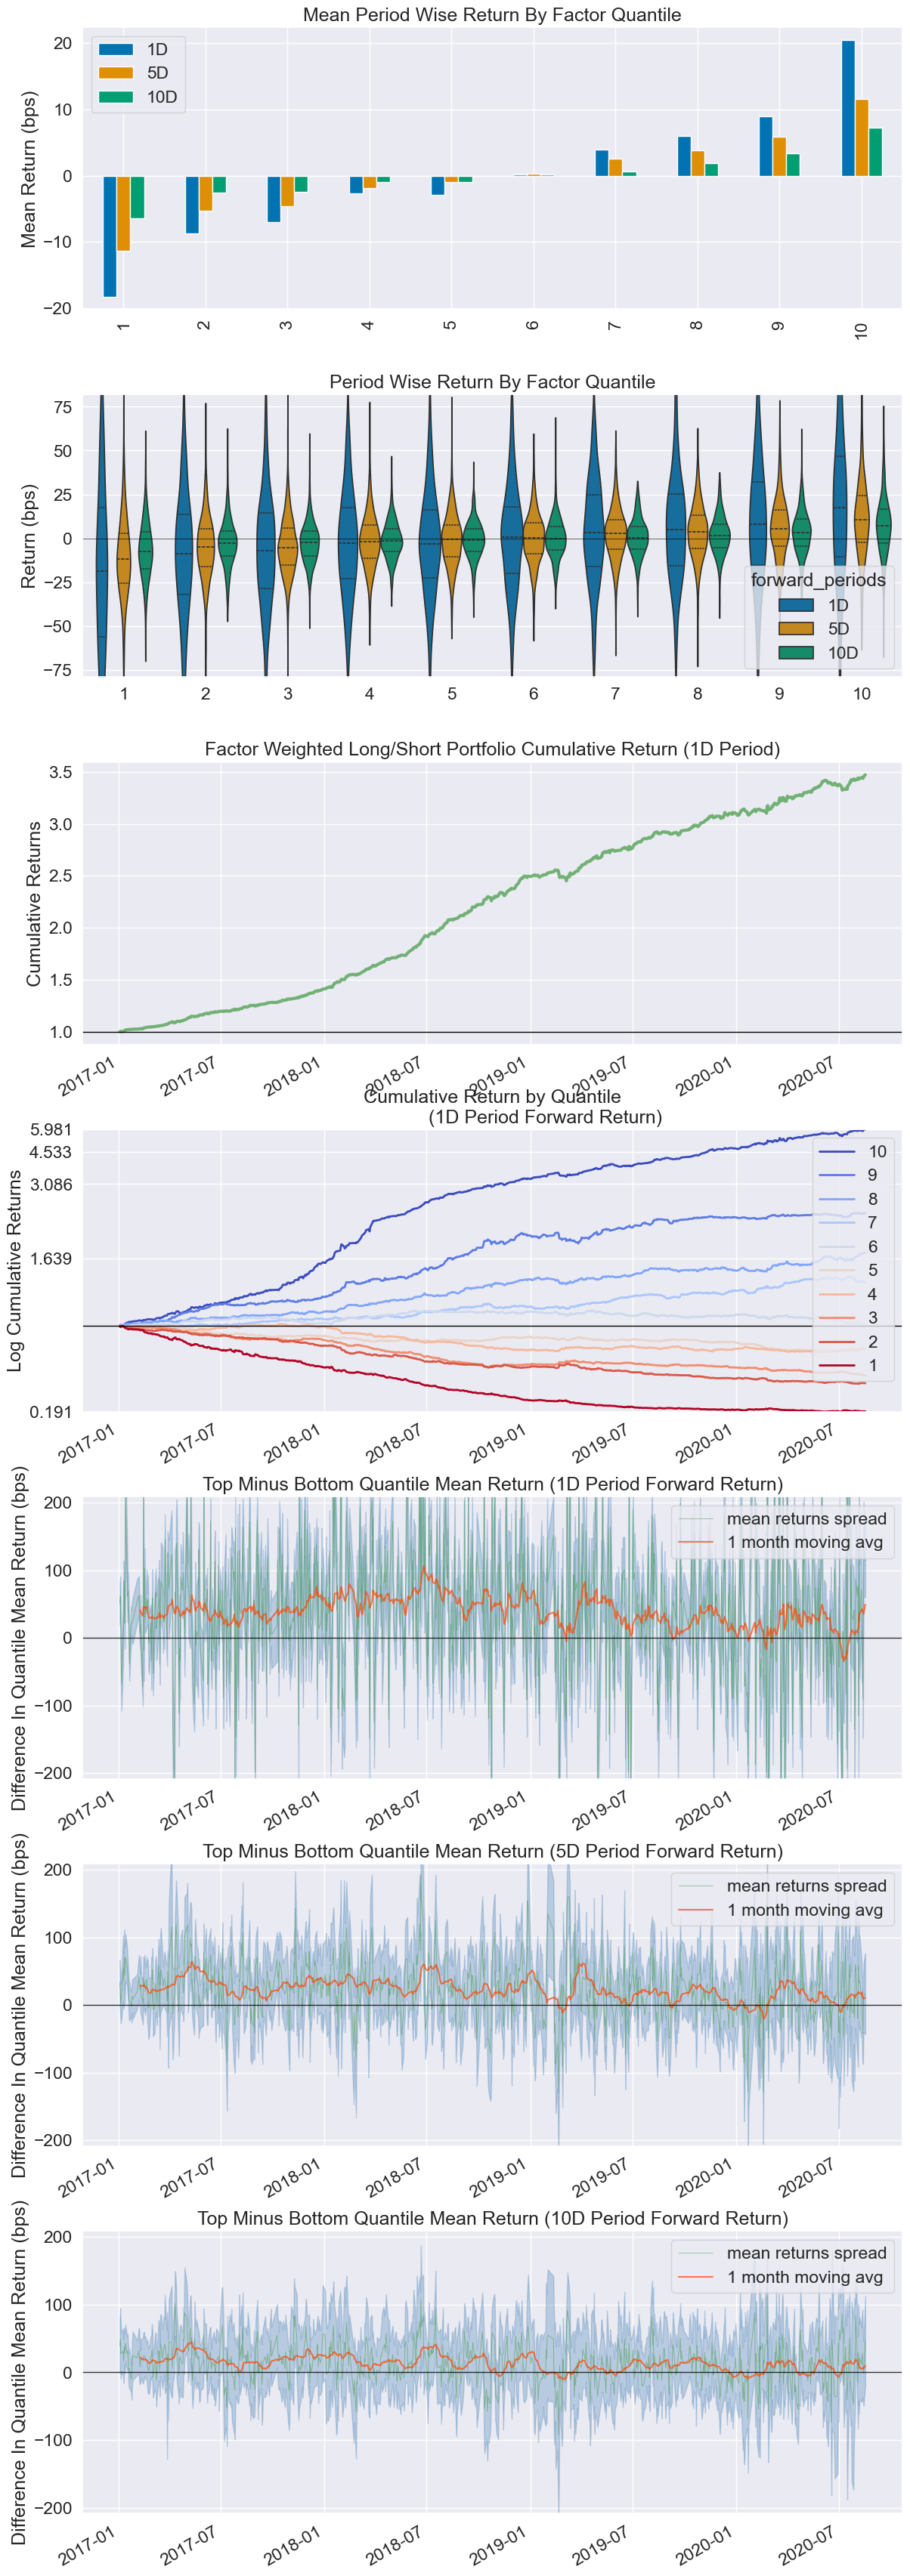

Information Analysis


1D      5D     10D
IC Mean            0.071   0.084   0.068
IC Std.            0.123   0.119   0.119
Risk-Adjusted IC   0.574   0.708   0.573
t-stat(IC)        17.035  21.015  17.020
p-value(IC)        0.000   0.000   0.000
IC Skew            0.027   0.011  -0.158
IC Kurtosis        0.394  -0.131   0.257

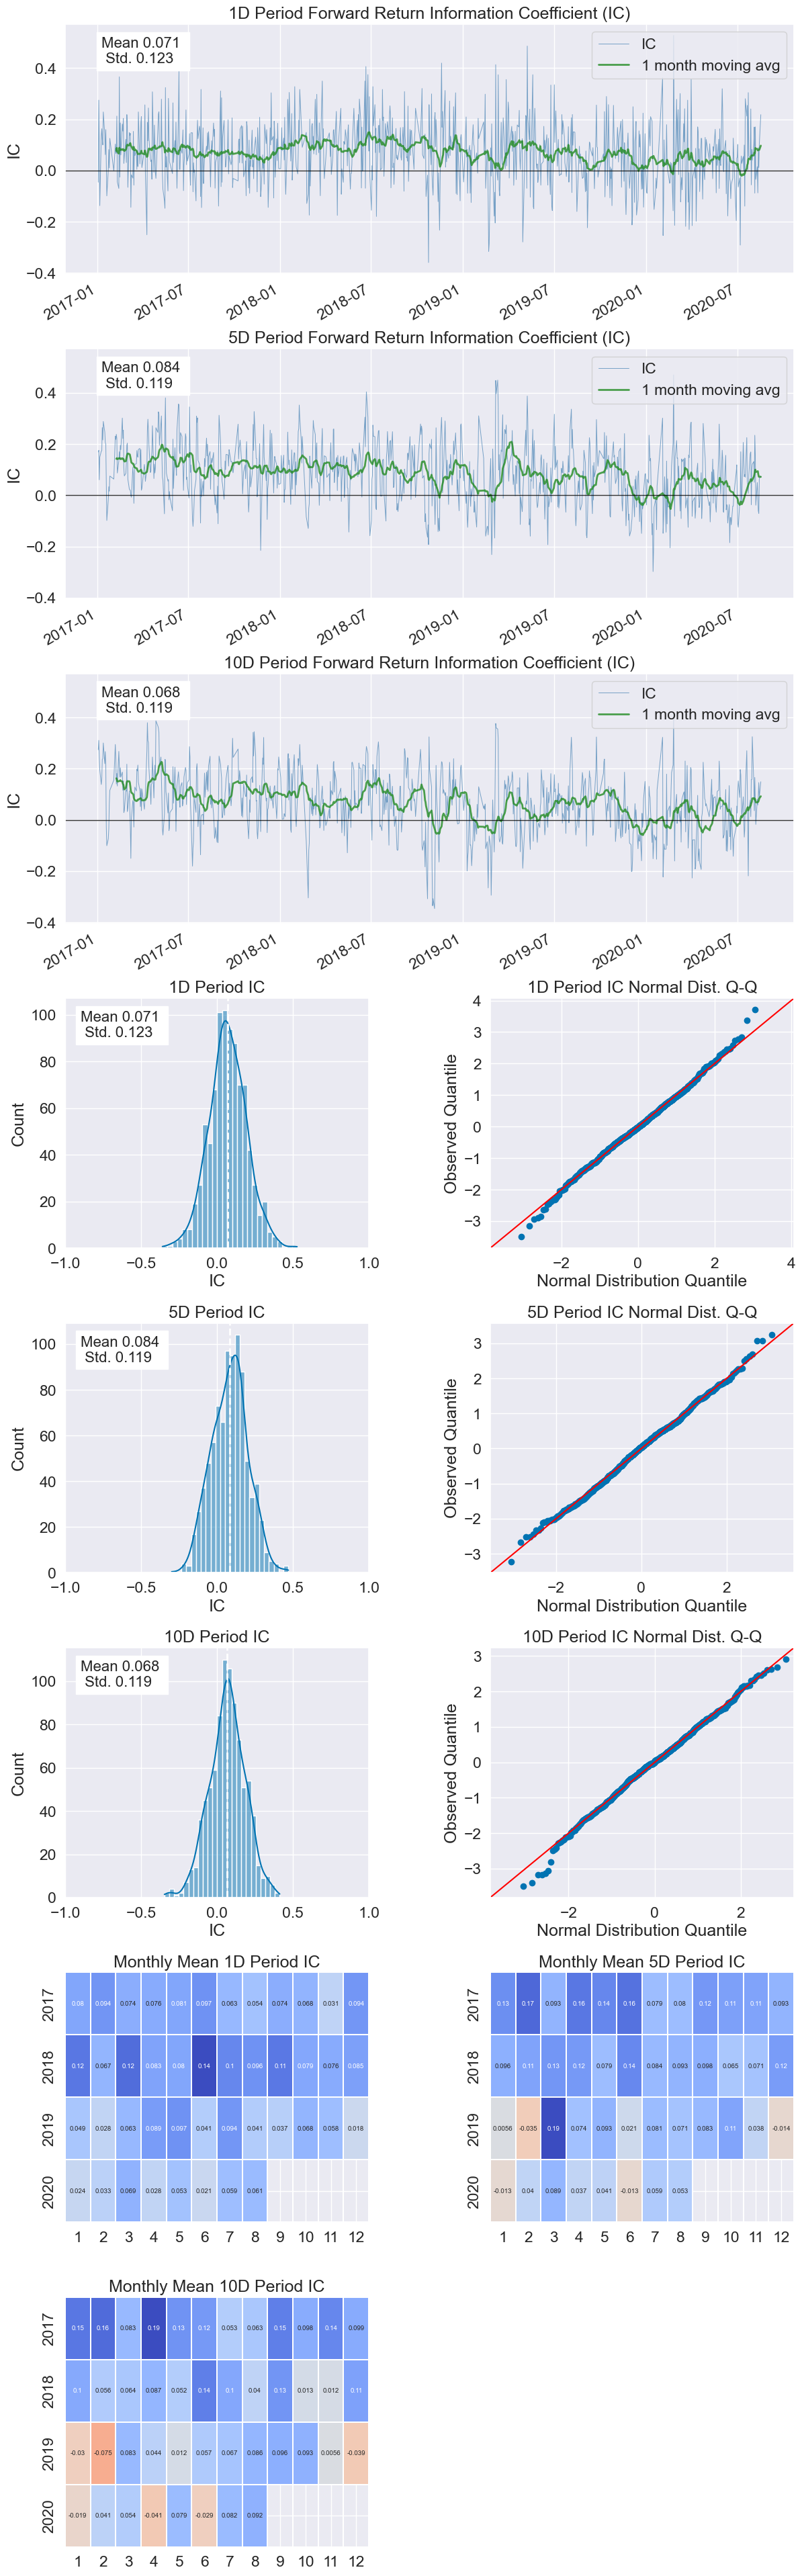

c:\Python313\Lib\site-packages\alphalens\utils.py:928: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


Turnover Analysis


1D     5D    10D
Quantile 1 Mean Turnover    0.577  0.805  0.835
Quantile 2 Mean Turnover    0.786  0.876  0.883
Quantile 3 Mean Turnover    0.827  0.883  0.884
Quantile 4 Mean Turnover    0.846  0.887  0.891
Quantile 5 Mean Turnover    0.857  0.890  0.894
Quantile 6 Mean Turnover    0.858  0.890  0.895
Quantile 7 Mean Turnover    0.848  0.888  0.889
Quantile 8 Mean Turnover    0.829  0.880  0.890
Quantile 9 Mean Turnover    0.789  0.875  0.884
Quantile 10 Mean Turnover   0.578  0.828  0.858

1D    5D    10D
Mean Factor Rank Autocorrelation  0.598  0.16  0.109

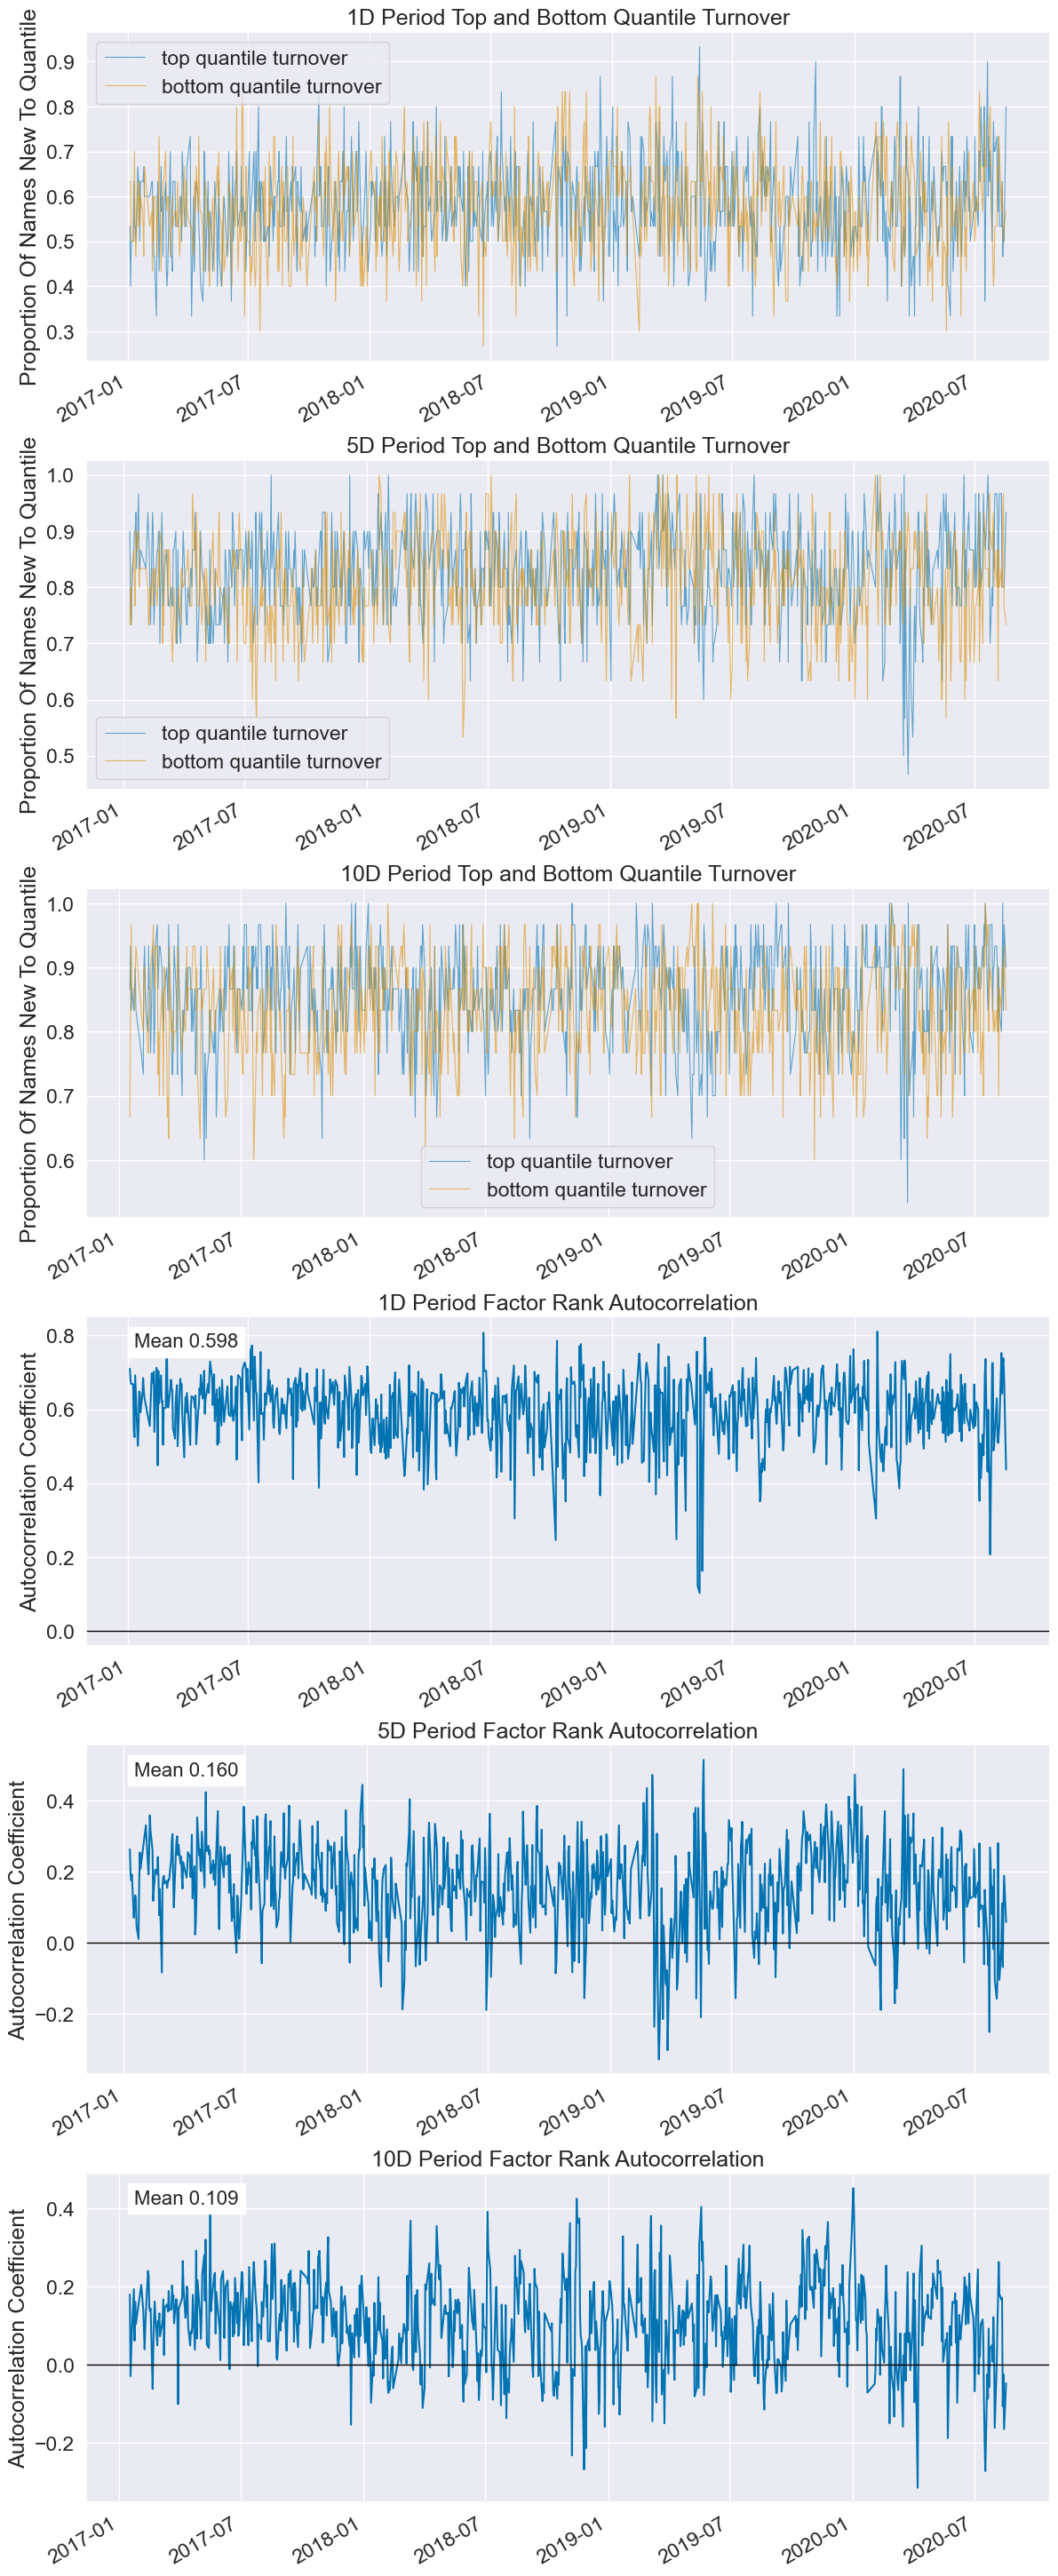

In [16]:
# 检查信号绩效
dataset.show_signal_performance(signal)

In [17]:
# 保存信号数据
lab.save_signal(name, signal)

# 策略回测

In [18]:
# 加载模块
import importlib
from datetime import datetime

from vnpy.alpha.strategy import BacktestingEngine

import vnpy.alpha.strategy.strategies.equity_demo_strategy as equity_demo_strategy

In [19]:
# 重载策略类
importlib.reload(equity_demo_strategy)
EquityDemoStrategy = equity_demo_strategy.EquityDemoStrategy

In [20]:
# 从文件加载信号数据
signal = lab.load_signal(name)

In [21]:
# 创建回测引擎对象
engine = BacktestingEngine(lab)

# 设置回测参数
engine.set_parameters(
    vt_symbols=component_symbols,
    interval=Interval.DAILY,
    start=datetime(2017, 1, 1),
    end=datetime(2020, 8, 1),
    capital=100000000,
)

# 添加策略实例
setting = {"top_k": 30, "n_drop": 3, "hold_thresh": 3}
engine.add_strategy(EquityDemoStrategy, setting, signal)

In [22]:
# 执行回测任务
engine.load_data()
engine.run_backtesting()
engine.calculate_result()
engine.calculate_statistics()
engine.show_chart()

2025-03-27 11:01:25 开始加载历史数据


100%|██████████| 819/819 [00:11<00:00, 72.55it/s]

2025-03-27 11:01:36 部分合约历史数据为空：['300866.SZSE', '300919.SZSE', '000527.SZSE', '600941.SSE', '688303.SSE', '600102.SSE', '600087.SSE', '600938.SSE', '688065.SSE', '000562.SZSE', '688223.SSE', '300888.SZSE', '601268.SSE', '600631.SSE', '600786.SSE', '688041.SSE', '600905.SSE', '601995.SSE', '601825.SSE', '300957.SZSE', '600357.SSE', '688187.SSE', '000024.SZSE', '300896.SZSE', '601299.SSE', '605117.SSE', '001289.SZSE', '600591.SSE', '601059.SSE', '601868.SSE', '300979.SZSE', '688271.SSE', '300999.SZSE', '600832.SSE', '601728.SSE', '600001.SSE', '301269.SZSE', '605499.SSE']
2025-03-27 11:01:36 所有历史数据加载完成
2025-03-27 11:01:36 策略初始化完成
2025-03-27 11:01:36 开始回放历史数据


2025-03-27 11:01:41 历史数据回放结束
2025-03-27 11:01:41 开始计算逐日盯市盈亏
2025-03-27 11:01:42 逐日盯市盈亏计算完成
2025-03-27 11:01:42 开始计算策略统计指标
2025-03-27 11:01:42 ------------------------------
2025-03-27 11:01:42 首个交易日：  2017-01-03
2025-03-27 11:01:42 最后交易日：  2020-07-31
2025-03-27 11:01:42 总交易日：  871
2025-03-27 11:01:42 盈利交易日：  475
2025-03-27 11:01:42 亏损交易日：  395
2025-03-27 11:01:42 起始资金：  100,000,000.00
2025-03-27 11:01:42 结束资金：  263,895,181.43
2025-03-27 11:01:42 总收益率：  163.90%
2025-03-27 11:01:42 年化收益：  45.16%
2025-03-27 11:01:42 最大回撤:   -42,550,679.47
2025-03-27 11:01:42 百分比最大回撤: -17.42%
2025-03-27 11:01:42 最长回撤天数:   18
2025-03-27 11:01:42 总盈亏：  163,895,181.43
2025-03-27 11:01:42 总手续费：  20,551,179.03
2025-03-27 11:01:42 总成交金额：  27,427,880,311.09
2025-03-27 11:01:42 总成交笔数：  4748
2025-03-27 11:01:42 日均盈亏：  188,168.98
2025-03-27 11:01:42 日均手续费：  23,594.92
2025-03-27 11:01:42 日均成交金额：  31,490,103.69
2025-03-27 11:01:42 日均成交笔数：  5.451205510907004
2025-03-27 11:01:42 日均收益率：  0.12%
2025-03-27 11:01:42 收益标准差： 

In [23]:
# 显示超额收益分析结果
engine.show_performance(benchmark_symbol=index_symbol)